In [2]:
import numpy as np
from sklearn.datasets import make_low_rank_matrix
from scipy import sparse
import scipy.sparse as spsp
import scipy as sp
import scipy.sparse
from scipy.sparse.linalg import norm
from scipy.sparse.linalg import inv
import pandas as pd
from scipy.special import lambertw
from copy import deepcopy

## Ridge leverage

In [213]:
def ridge_sampling(A, t):
    eps = 1e-8
    indexes = np.random.choice(A.shape[1], A.shape[1] // 2, replace=False)
    Cu = A[:, indexes]
    if Cu.shape[1] // 2 > 5 * t:
        Cu, indexes = ridge_sampling(Cu, int(5 * t))
    
    k = int(np.exp(lambertw(t)).real)
    if scipy.sparse.issparse(A):
        U, s, Vt = scipy.sparse.linalg.svds(Cu, k=k)
    else:
        U, s, Vt = np.linalg.svd(Cu, full_matrices=False)
        U, s, Vt = U[:, :k], s[:k], Vt[:k, :]
        
    lmbda = np.linalg.norm(Cu - (U * s) @ Vt) ** 2 / k
    matrix_for_scores = np.linalg.pinv(Cu @ Cu.T + lmbda * np.eye(Cu.shape[0]))
    
    ridge_scores = np.zeros(Cu.shape[1])
    for i in range(Cu.shape[1]):
        ridge_scores[i] = Cu[:, i].T @ matrix_for_scores @ Cu[:, i]

    ridge_scores += eps
    ridge_scores /= np.sum(ridge_scores)
    
    final_indexes = np.random.choice(indexes, t, replace=False, p=ridge_scores)
    return A[:, final_indexes], final_indexes

def get_CUR_ridge(A, k):
    C, col_ind = ridge_sampling(A, k)
    R, row_ind = ridge_sampling(A.T, k)
    R = R.T
    if scipy.sparse.issparse(A):
        U = np.linalg.pinv(C.toarray()) @ A @ np.linalg.pinv(R.toarray())
    else:
        U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)
    return C, U, R

In [214]:
def ridge_sampling_randomized(A, t):
    eps = 1e-8
    indexes = np.random.choice(A.shape[1], A.shape[1] // 2, replace=False)
    Cu = A[:, indexes]
    if Cu.shape[1] // 2 > 5 * t:
        Cu, indexes = ridge_sampling_randomized(Cu, int(5 * t))
    
    k = int(np.exp(lambertw(t)).real)
    
    if scipy.sparse.issparse(A):
        U, s, Vt = scipy.sparse.linalg.svds(Cu, k=min(min(Cu.shape) - 1, k))
    else:
        U, s, Vt = np.linalg.svd(Cu, full_matrices=False)
        U, s, Vt = U[:, :k], s[:k], Vt[:k, :]
                
    lmbda = np.linalg.norm(Cu - (U * s) @ Vt) ** 2 / k
    
    new_shape = (min(2000, Cu.shape[0]), min(2000, Cu.shape[1]))
    if new_shape != Cu.shape: # matrix is too big
        niters = 3
        row_ind = np.random.choice(Cu.shape[0], new_shape[0], replace=False)
        col_ind = np.random.choice(Cu.shape[1], new_shape[1], replace=False)
        ridge_scores = np.zeros(Cu.shape[1])
        for iter in range(niters):
            matrix_for_scores = np.linalg.pinv(Cu[row_ind][:, col_ind] @ Cu[row_ind][:, col_ind].T +\
                                               lmbda * np.eye(new_shape[0]))
            ridge_scores_cur = np.zeros(Cu.shape[1])
            for i in range(Cu.shape[1]):
                ridge_scores_cur[i] = Cu[row_ind, i].T @ matrix_for_scores @ Cu[row_ind, i]
            ridge_scores += ridge_scores_cur
        
        ridge_scores /= niters
    
    else:
        matrix_for_scores = np.linalg.pinv(Cu @ Cu.T + lmbda * np.eye(Cu.shape[0]))
    
        ridge_scores = np.zeros(Cu.shape[1])
        for i in range(Cu.shape[1]):
            ridge_scores[i] = Cu[:, i].T @ matrix_for_scores @ Cu[:, i]

    ridge_scores += eps
    ridge_scores /= np.sum(ridge_scores)
    
    final_indexes = np.random.choice(indexes, t, replace=False, p=ridge_scores)
    return A[:, final_indexes], final_indexes

def get_CUR_ridge_randomized(A, k):
    C, col_ind = ridge_sampling_randomized(A, k)
    R, row_ind = ridge_sampling_randomized(A.T, k)
    R = R.T
    if scipy.sparse.issparse(A):
        U = np.linalg.pinv(C.toarray()) @ A @ np.linalg.pinv(R.toarray())
    else:
        U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)
    return C, U, R

In [190]:
def get_trunc_SVD(A, k):
    if scipy.sparse.issparse(A):
        U, s, Vt = scipy.sparse.linalg.svds(A, k=k)
    else:
        U, s, Vt = np.linalg.svd(A)
        U, s, Vt = U[:, :k], s[:k], Vt[:k, :]
    return U, s, Vt

In [134]:
n = 1000
k = 20
A = sparse.random(n, n, density=0.1, format='csr')
U, s, Vt = scipy.sparse.linalg.svds(A, k=k)
A = (U * s) @ Vt

In [164]:
C, U, R = get_CUR_ridge(A, k)
print(C.shape)
print(np.linalg.norm(A - C @ U @ R))

(1000, 100)
12.436755474414158


In [197]:
C, U, R = get_CUR_ridge_randomized(A, k)
print(C.shape)
print(np.linalg.norm(A - C @ U @ R))

(1000, 250) (1000, 17) (17, 250)
(1000, 50) (1000, 5) (5, 50)
(1000, 250) (1000, 17) (17, 250)
(1000, 50) (1000, 5) (5, 50)
(1000, 10)
4.610340714718539e-11


In [138]:
U, s, Vt = get_trunc_SVD(A, k)
print(np.linalg.norm(A - (U * s) @ Vt))

1.1711175755111905e-13


In [160]:
A = make_low_rank_matrix(1000, 1000, 100)
k = 100

In [200]:
k

10

### Naive CUR - baseline

In [156]:
def rand_sample(A, k):
    _, n = A.shape
    cols = np.random.choice(n, k, replace=False)
    R = A[:, cols]
    return R, cols

def get_CUR_naive(A, k):
    C, col_ind = rand_sample(A, k)
    R, row_ind = rand_sample(A.T, k)
    R = R.T
    if scipy.sparse.issparse(A):
        U = np.linalg.pinv(C.toarray()) @ A @ np.linalg.pinv(R.toarray())
    else:
        U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)
    return C, U, R

In [143]:
C, U, R, col_ind, row_ind = get_CUR_naive(A, k)
print(C.shape)
print(np.linalg.norm(A - C @ U @ R))

(1000, 20)
3.171890899350402e-12


### CUR approximation

In [313]:
def sample_cols_probs(A, r):
    if spsp.issparse(A):
        norms = spsp.linalg.norm(A, axis=0)  # норма по стоблцам
        norm_A = spsp.linalg.norm(A)
    else:
        norms = np.linalg.norm(A, axis=0)  # норма по стоблцам
        norm_A = np.linalg.norm(A)
    norm_probs = norms / norm_A  # нормы переводим в вероятности
    norm_probs /= np.sum(norm_probs)  # нормы переводим в вероятности
    norm_probs = norm_probs + 1e-9
    norm_probs /= np.sum(norm_probs)
    picked_cols = np.random.choice(A.shape[1], r, p=norm_probs, replace=False)
    return picked_cols, norm_probs

In [13]:
def get_columns(A, r):
    picked_cols, norm_probs = sample_cols_probs(A, r)
    C = A[:, picked_cols]
    if spsp.issparse(A):
        D1 = spsp.diags(1 / np.sqrt(r * norm_probs[picked_cols]))
        C1 = C @ D1
        U, S, Vt = spsp.linalg.svds(C1.T @ C1)
    else:
        D1 = np.diag(1 / np.sqrt(r * norm_probs[picked_cols]))
        C1 = C @ D1
        U, S, Vt = np.linalg.svd(C1.T @ C1)
    k = S[S > 1e-6].size  # in order to avoid 1 / 0
    compliment_C = (U[:, :k] * (1 / S[:k])) @ Vt[:k] # truncated SVD + compliment
    return C, C1, D1, compliment_C

In [14]:
def get_rows(A, r):
    picked_rows, norm_probs = sample_cols_probs(A.T, r)
    R = A[picked_rows]
    m = A.shape[0]
    if spsp.issparse(A):
        D2 = spsp.diags(1 / np.sqrt(r * norm_probs[picked_rows]))
        row = np.array(range(r))
        col = picked_rows
        W = spsp.csr_matrix(spsp.coo_matrix((np.ones(r), (row, col)), shape=(r, m)))      
    else:
        D2 = np.diag(1 / np.sqrt(r * norm_probs[picked_rows]))
        W = np.zeros((r, m))
        w_idxs = list(zip(range(r), picked_rows))
        for idx in w_idxs:
            W[idx] = 1
    return R, D2, W

In [15]:
def get_CUR_approx(A, r):
    C, C1, D1, comp_C1 = get_columns(A, r)
    R, D2, W = get_rows(A, r)
    U = D1 @ comp_C1 @ C1.T @ W.T @ D2 @ D2
    return C, U, R

In [279]:
C, U, R = get_CUR_approx(A, k)
print(C.shape)
print(np.linalg.norm(A - C @ U @ R))

(1000, 50)
493.87631811498284


### Sampling by norm

In [218]:
def get_CUR_sample_l2_norm(A, k):
    col_ind, _ = sample_cols_probs(A, k)
    row_ind, _ = sample_cols_probs(A.T, k)
    R = A[row_ind]
    C = A[:, col_ind]
    if scipy.sparse.issparse(A):
        U = np.linalg.pinv(C.toarray()) @ A @ np.linalg.pinv(R.toarray())
    else:
        U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)
    return C, U, R

### Randomized pseudoskeleton

In [16]:
def rand_pseudo_skeleton(A, k):
    n, m = A.shape
    rows = np.random.choice(n, k)
    R = A[rows]
    cols = np.random.choice(m, k)
    C = A[:, cols]
    if spsp.issparse(A):
        A_sub = A[rows]
        A_sub = A_sub[:, cols]
        U, S, Vt = spsp.linalg.svds(A_sub)
    else:
        A_sub = A[np.ix_(rows, cols)]
        U, S, Vt = np.linalg.svd(A_sub)
    r = k // 2
    U = np.linalg.pinv((U[:, :r] * S[:r]) @ Vt[:r])
    return C, U, R

In [268]:
C, U, R = rand_pseudo_skeleton(A, 2 * k)
print(C.shape)
print(np.linalg.norm(A - C @ U @ R))

(1000, 100)
4.5390103640026744e-12


### Statistical leverage

In [144]:
def ColumnSelect(A, k, eps):
    m, n = np.shape(A)
    if not scipy.sparse.issparse(A):
        u, s, vh = np.linalg.svd(A)
        v = vh[:k,:]
    else:
        u, s, v = scipy.sparse.linalg.svds(A, k=k)
     
    v_squared = np.square(v)
    pi = np.sum(v_squared, axis=0)/k

    cols = np.random.choice(n, size=k, replace=False, p=pi)
    C = A[:, cols]
            
    return C, cols

def CUR_leverage(A, k, eps):
    C, col_ind = ColumnSelect(A, k, eps)
    R, row_ind = ColumnSelect(A.T, k, eps)
    R = R.T
    
    if scipy.sparse.issparse(A):
        U = np.linalg.pinv(C.toarray()) @ A @ np.linalg.pinv(R.toarray())
    else:
        U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)
    #U = scipy.sparse.csr_matrix(U)
    
    return C, U, R

In [145]:
eps = 1
C, U, R = CUR_leverage(A, k, eps)
print(C.shape)
print(np.linalg.norm(A - C @ U @ R))

(1000, 20)
6.1813735687388135e-12


### Quasi Gram-Schmidt

In [18]:
def quasi_Gram_Schmidt(A, k):
    n = np.shape(A)[0]
      
    rho = np.linalg.norm(A[:,0])
    R = np.array(rho).reshape((1,1))
    
    B = np.copy(A)
    
    for j in range(1,k):
        
        R_tilde = np.concatenate((R, np.linalg.inv(R).T @ B[:,:j].T @ B[:,j:]), axis=1)
        norm = []
        for i in range(j,n):
            res = np.linalg.norm(B[:,i],2)**2 - np.linalg.norm(R_tilde[:j,i])**2
            norm.append((res,i))
        norm = sorted(norm, reverse=True, key = lambda x: x[0])
        g = norm[0][1]
        B[:, [j,g]] = B[:, [g,j]]
        
        d = B[:,j].T @ B[:,:j]
        r = (d @ np.linalg.pinv(R)).T
        p = np.linalg.pinv(R) @ r 
        q = B[:,j] - B[:,:j] @ p
        d = q.T @ B[:,:j]
        s = (d @ np.linalg.pinv(R)).T
        r += s
        p = np.linalg.pinv(R) @ s
        q -= B[:,:j] @ s
        rho = np.linalg.norm(q)
        
        zero = np.zeros((1,j))
        
        R = np.append(R, zero, axis=0)
        l = np.append(r, rho).reshape((j+1,1))
        R = np.append(R, l, axis=1)
        
    return B, R

In [19]:
def quasi_Gram_Schmidt_sp(A, k):
    n = np.shape(A)[0]
    #print(type(A))
    #print(scipy.sparse.linalg.norm(A))
    rho = norm(A[:,0])
    R = sparse.csc_matrix(rho).reshape((1,1))
    #Q = A[:,0] / rho
    #Q = Q.reshape((n,1))
    
    B = A.copy().tocsc()
    
    for j in range(1,k):
        
        R_tilde = sparse.hstack([R, inv(R).T @ B[:,:j].T @ B[:,j:]]).tocsc()
        norm_col = []
        for i in range(j,n):
            res = norm(B[:,i])**2 - norm(R_tilde[:j,i])**2
            norm_col.append((res,i))
        norm_col = sorted(norm_col, reverse=True, key = lambda x: x[0])
        g = norm_col[0][1]
        B = B.tolil()
        B[:, [j,g]] = B[:, [g,j]]
        B = B.tocsr()
        
        d = B[:,j].T @ B[:,:j]
        r = (d @ inv(R).reshape((j,j))).T
        p = inv(R) @ r
        p = p.reshape((j,1))
        q = B[:,j] - B[:,:j] @ p
        d = q.T @ B[:,:j]
        s = (d @ inv(R)).T
        r += s
        p = inv(R) @ s
        q -= B[:,:j] @ s

        q = scipy.sparse.csc_matrix(q)
        rho = norm(q)
        
        zero = np.zeros((1,j))
        zero = sparse.csc_matrix(zero)
        
        R = sparse.vstack([R, zero])
        l = sparse.vstack([r, rho]).reshape((j+1,1))
        R = sparse.hstack([R, l])
        R = R.tocsc()
        
    return B, R

In [20]:
def SCR(A, k):
    if not sparse.issparse(A):
        B, R = quasi_Gram_Schmidt(A, k)
        X = B[:,:k]
        B_, S = quasi_Gram_Schmidt(A.T, k)
        Y = B_[:,:k]

        T = X.T @ B @ Y
        T = np.linalg.inv(R) @ np.linalg.inv(R).T @ T @ np.linalg.inv(S) @ np.linalg.inv(S).T
    
    else:
        B, R = quasi_Gram_Schmidt_sp(A, k)
        X = B[:,:k]
        B_, S = quasi_Gram_Schmidt_sp(A.T, k)
        Y = B_[:,:k]
        
        T = X.T @ B @ Y
        T = inv(R) @ inv(R).T @ T @ inv(S) @ inv(S).T
    
    return B, X, T, Y 

In [286]:
B, X, T, Y = SCR(A, k)
np.linalg.norm(B - X @ T @ Y.T)

51.63062152370802

### Maxvol

In [242]:
def idxs_from_flatten(flatten_idx, shape):
    _, n = shape
    i = flatten_idx // n
    j = flatten_idx % n
    return i, j

def swap_rows(A, i, j):
    temp_row = copy.deepcopy(A[i])
    A[i] = copy.deepcopy(A[j])
    A[j] = temp_row
    return A

def maxvol_ridge(data, r):
    # matrix should be nxr
    A = deepcopy(data)
    if spsp.issparse(data):
        A = spsp.lil.lil_matrix(A)
    if A.shape[1] > r:
        A, cols = ridge_sampling_randomized(A, r)
    _, rows = ridge_sampling_randomized(A.T, r) # sample rows
    rest_rows = np.array(list(set(range(0, A.shape[0])) - set(rows)))
    swapped_rows = []
    max_elem_in_B = 2
    delta = 1e-3
    iters = 0
    while max_elem_in_B > 1 + delta and iters < r:
        A_sub = A[rows]
        if spsp.issparse(data):
            A = spsp.lil.lil_matrix(spsp.vstack([A_sub, A[rest_rows]]))
            B = A @ sp.linalg.pinv(A_sub.toarray())
        else:
            A = np.vstack([A_sub, A[rest_rows]])
            B = A @ np.linalg.pinv(A_sub)
        arg_max_b = r * B.shape[1] + np.argmax(B[r:])
        i, j = idxs_from_flatten(arg_max_b, B.shape)
        max_elem_in_B = B[i, j]
        if max_elem_in_B > 1:
            B = swap_rows(B, i, j)
            A = swap_rows(A, i, j) # update idxs of rows which need to return
            rows[j] = i
            rest_rows[i - r] = j
        iters += 1      
    return rows

def maxvol_statistical(data, r):
    # matrix should be nxr
    A = deepcopy(data)
    if spsp.issparse(data):
        A = spsp.lil.lil_matrix(A)
        
    _, rows = ColumnSelect(A.T, r, 1) # sample rows
    if A.shape[1] > r:
        A, cols = ColumnSelect(A, r, 1)
    
    rest_rows = np.array(list(set(range(0, A.shape[0])) - set(rows)))
    swapped_rows = []
    max_elem_in_B = 2
    delta = 1e-3
    iters = 0
    while max_elem_in_B > 1 + delta and iters < r:
        A_sub = A[rows]
        if spsp.issparse(data):
            A = spsp.lil.lil_matrix(spsp.vstack([A_sub, A[rest_rows]]))
            B = A @ sp.linalg.pinv(A_sub.toarray())
        else:
            A = np.vstack([A_sub, A[rest_rows]])
            B = A @ np.linalg.pinv(A_sub)
        arg_max_b = r * B.shape[1] + np.argmax(B[r:])
        i, j = idxs_from_flatten(arg_max_b, B.shape)
        max_elem_in_B = B[i, j]
        if max_elem_in_B > 1:
            B = swap_rows(B, i, j)
            A = swap_rows(A, i, j) # update idxs of rows which need to return
            rows[j] = i
            rest_rows[i - r] = j
        iters += 1      
    return rows

def maxvol_naive(data, r):
    # matrix should be nxr
    A = deepcopy(data)
    if spsp.issparse(data):
        A = spsp.lil.lil_matrix(A)
    if A.shape[1] > r:
        A, cols = rand_sample(A, r)
    _, rows = rand_sample(A.T, r) # sample rows
    rest_rows = np.array(list(set(range(0, A.shape[0])) - set(rows)))
    swapped_rows = []
    max_elem_in_B = 2
    delta = 1e-3
    iters = 0
    while max_elem_in_B > 1 + delta and iters < r:
        A_sub = A[rows]
        if spsp.issparse(data):
            A = spsp.lil.lil_matrix(spsp.vstack([A_sub, A[rest_rows]]))
            B = A @ sp.linalg.pinv(A_sub.toarray())
        else:
            A = np.vstack([A_sub, A[rest_rows]])
            B = A @ np.linalg.pinv(A_sub)
        arg_max_b = r * B.shape[1] + np.argmax(B[r:])
        i, j = idxs_from_flatten(arg_max_b, B.shape)
        max_elem_in_B = B[i, j]
        if max_elem_in_B > 1:
            B = swap_rows(B, i, j)
            A = swap_rows(A, i, j) # update idxs of rows which need to return
            rows[j] = i
            rest_rows[i - r] = j
        iters += 1      
    return rows

def maxvol_cols_probs(data, r):
    # matrix should be nxr
    A = deepcopy(data)
    if spsp.issparse(data):
        A = spsp.lil.lil_matrix(A)
    if A.shape[1] > r:
        cols, _ = sample_cols_probs(A, r) # sample columns
        A = A[:, cols]
    rows, _ = sample_cols_probs(A.T, r) # # sample rows
    rest_rows = np.array(list(set(range(0, A.shape[0])) - set(rows)))
    swapped_rows = []
    max_elem_in_B = 2
    delta = 1e-3
    iters = 0
    while max_elem_in_B > 1 + delta and iters < r:
        A_sub = A[rows]
        if spsp.issparse(data):
            A = spsp.lil.lil_matrix(spsp.vstack([A_sub, A[rest_rows]]))
            B = A @ sp.linalg.pinv(A_sub.toarray())
        else:
            A = np.vstack([A_sub, A[rest_rows]])
            B = A @ np.linalg.pinv(A_sub)
        arg_max_b = r * B.shape[1] + np.argmax(B[r:])
        i, j = idxs_from_flatten(arg_max_b, B.shape)
        max_elem_in_B = B[i, j]
        if max_elem_in_B > 1:
            B = swap_rows(B, i, j)
            A = swap_rows(A, i, j) # update idxs of rows which need to return
            rows[j] = i
            rest_rows[i - r] = j
        iters += 1      
    return rows

In [292]:
def get_CUR_maxvol(A, k, func):
    rows = func(A, k)
    R = A[rows]
    cols = func(R.T, k)
    C = A[:, cols]
    if scipy.sparse.issparse(A):
        U = np.linalg.pinv(C.toarray()) @ A @ np.linalg.pinv(R.toarray())
    else:
        U = np.linalg.pinv(C) @ A @ np.linalg.pinv(R)
    #U = scipy.sparse.csr_matrix(U)
    print(np.linalg.norm(A - C @ U @ R))
    
    return C, U, R

In [210]:
C, U, R = get_CUR_maxvol(A, k, maxvol_cols_probs)

In [178]:
print(C.shape, U.shape, R.shape)

(1000, 200) (200, 200) (200, 1000)


In [177]:
print(np.linalg.norm(A - C @ U @ R))

11.765371447347025


## Testing accuracy

In [308]:
n = 3000
rank = 30
A = np.random.random((n, n))
U, s, Vt = np.linalg.svd(A)
A = (U[:, :rank] * s[:rank]) @ Vt[:rank, :]
k = 30

In [310]:
#dense random matrix
print('SVD')
U, s, Vt = get_trunc_SVD(A, k)
print(np.linalg.norm(A - (U * s) @ Vt))
print()

print('Ridge')
C, U, R = get_CUR_ridge(A, k)
print(np.linalg.norm(A - C @ U @ R))
print()

print('Randomized ridge')
C, U, R = get_CUR_ridge_randomized(A, k)
print(np.linalg.norm(A - C @ U @ R))
print()

print('Stat. leverage')
eps = 1
C, U, R = CUR_leverage(A, k, eps)
print(np.linalg.norm(A - C @ U @ R))
print()

print('Quasi GS')
B, X, T, Y = SCR(A, k)
print(np.linalg.norm(B - X @ T @ Y.T))
print()

print('Pseudo skeleton')
C, U, R = rand_pseudo_skeleton(A, k)
print(np.linalg.norm(A - C @ U @ R))
print()

print('CUR approximation')
C, U, R = get_CUR_approx(A, k)
print(np.linalg.norm(A - C @ U @ R))
print()

print('CUR norms')
C, U, R = get_CUR_sample_l2_norm(A, k)
print(np.linalg.norm(A - C @ U @ R))
print()

print('Naive CUR')
C, U, R = get_CUR_naive(A, k)
print(np.linalg.norm(A - C @ U @ R))
print()

for func in [maxvol_naive, maxvol_ridge, maxvol_statistical, maxvol_cols_probs]:
    print(func)
    C, U, R = get_CUR_maxvol(A, k, func)
    print(np.linalg.norm(A - C @ U @ R))
    print()

SVD
1.537589807984485e-12

Ridge
6.235076881575452e-11

Randomized ridge
1.0543912622732116e-10

Stat. leverage
7.620684104243382e-11

Quasi GS
38.01232825955902

Pseudo skeleton
147.29324804838987

CUR approximation
1439.6457435674627

CUR norms
7.547069781037258e-10

Naive CUR
6.654916565719917e-11

<function maxvol_naive at 0x7f920eb52510>
6.883479508837098e-10
6.883479508837098e-10

<function maxvol_ridge at 0x7f9212579f28>
31.165794243856727
31.165794243856727

<function maxvol_statistical at 0x7f9212579620>
31.680173905473552
31.680173905473552

<function maxvol_cols_probs at 0x7f92116da378>
1.302611040824097e-10
1.302611040824097e-10



In [3]:
movies = pd.read_csv('./ml-latest-small/movies.csv', index_col='movieId', header=0, encoding='unicode-escape')
ratings = pd.read_csv('./ml-latest-small/ratings.csv', header=0)

In [4]:
best_movies = "lord of the rings"
target_movies = movies.loc[movies.title.str.contains(best_movies, flags=2)]
target_movies

,title,genres
movieId,,
2116,"Lord of the Rings, The (1978)",Adventure|Animation|Children|Fantasy
4993,"Lord of the Rings: The Fellowship of the Ring,...",Adventure|Fantasy
5952,"Lord of the Rings: The Two Towers, The (2002)",Adventure|Fantasy
7153,"Lord of the Rings: The Return of the King, The...",Action|Adventure|Drama|Fantasy


In [5]:
favorite_movies_ids = target_movies.index
data_matrix = scipy.sparse.csr_matrix((ratings.rating.values.astype('f8'), 
                               (ratings.userId.values, ratings.movieId.values)))

In [6]:
A = data_matrix
k = 30

In [238]:
# movielens

print('SVD')
U, s, Vt = get_trunc_SVD(A, k)
print(np.linalg.norm(A - (U * s) @ Vt))
print()

print('Randomized ridge')
C, U, R = get_CUR_ridge_randomized(A, k)
print(np.linalg.norm(A - C @ U @ R))
print()

print('Stat. leverage')
eps = 1
C, U, R = CUR_leverage(A, k, eps)
print(np.linalg.norm(A - C @ U @ R))
print()

print('CUR norms')
C, U, R = get_CUR_sample_l2_norm(A, k)
print(np.linalg.norm(A - C @ U @ R))
print()

print('Naive CUR')
C, U, R = get_CUR_naive(A, k)
print(np.linalg.norm(A - C @ U @ R))
print()

for func in [maxvol_cols_probs]:
    print(func)
    C, U, R = get_CUR_maxvol(A, k, func)
    print(np.linalg.norm(A - C @ U @ R))
    print()

Pseudo skeleton
1160.144172075178

CUR norms
1038.942742519901

Naive CUR
1155.5408580145938

<function maxvol_naive at 0x7f92119b4268>
1157.5786256118472

<function maxvol_ridge at 0x7f9212579620>


KeyboardInterrupt: 

In [314]:
A = scipy.io.loadmat('./California.mat')
A = A['Problem'][0][0][2] # csc matrix, full rank
k = 800

In [ ]:
A = scipy.io.loadmat('./EPA.mat')
A = A['Problem'][0][0][2] # csc matrix, full rank
k = 500

In [274]:
A = scipy.io.loadmat('./EVA.mat')
A = A['Problem'][0][0][2] # csc matrix, full rank
k = 900

In [275]:
A.shape

(8497, 8497)

In [276]:
# random sparse matrix
#dense random matrix

print('SVD')
U, s, Vt = get_trunc_SVD(A, k)
print(np.linalg.norm(A - (U * s) @ Vt))
print()

print('Randomized ridge')
C, U, R = get_CUR_ridge_randomized(A, k)
print(np.linalg.norm(A - C @ U @ R))
print()

print('Stat. leverage')
eps = 1
C, U, R = CUR_leverage(A, k, eps)
print(np.linalg.norm(A - C @ U @ R))
print()

print('CUR norms')
C, U, R = get_CUR_sample_l2_norm(A, k)
print(np.linalg.norm(A - C @ U @ R))
print()

print('Naive CUR')
C, U, R = get_CUR_naive(A, k)
print(np.linalg.norm(A - C @ U @ R))
print()

for func in [maxvol_cols_probs]:
    print(func)
    C, U, R = get_CUR_maxvol(A, k, func)
    print(np.linalg.norm(A - C @ U @ R))
    print()

SVD
19.437317006025502

Randomized ridge
65.60792283974617

Stat. leverage
49.50589362794262

CUR norms
45.243652943091256

Naive CUR
79.44345480796812

<function maxvol_cols_probs at 0x7f92119b4268>
8626880138.482277

<function maxvol_statistical at 0x7f9212579620>


ValueError: k must be between 1 and min(A.shape), k=900

### Timing

In [309]:
# dense random matrix
times = []

print('SVD')
res = %timeit -o -n1 -r3 get_trunc_SVD(A, k)
times.append(res.average)
print()

print('Ridge')
res = %timeit -o -n1 -r3 get_CUR_ridge(A, k)
times.append(res.average)
print()

print('Stat. leverage')
eps = 1
res = %timeit -o -n1 -r3 CUR_leverage(A, k, eps)
times.append(res.average)
print()

print('Quasi GS')
res = %timeit -o -n1 -r3 SCR(A, k)
times.append(res.average)
print()

print('Pseudo skeleton')
res = %timeit -o -n1 -r3 rand_pseudo_skeleton(A, k)
times.append(res.average)
print()

print('CUR approximation')
res = %timeit -o -n1 -r3 get_CUR_approx(A, k)
times.append(res.average)
print()

print('CUR norms')
res = %timeit -o -n1 -r3 get_CUR_sample_l2_norm(A, k)
times.append(res.average)
print()

print('Naive CUR')
res = %timeit -o -n1 -r3 get_CUR_naive(A, k)
times.append(res.average)
print()

for func in [maxvol_cols_probs]:
    print(func)
    res = %timeit -o -n1 -r3 get_CUR_maxvol(A, k, func)
    times.append(res.average)
    print()

SVD
16.5 s ± 2.91 s per loop (mean ± std. dev. of 3 runs, 1 loop each)

Ridge


KeyboardInterrupt: 

In [302]:
A = scipy.io.loadmat('./EPA.mat')
A = A['Problem'][0][0][2] # csc matrix, full rank
k = 500

In [283]:
# sparse random matrix
times = []

print('SVD')
res = %timeit -o -n1 -r3 get_trunc_SVD(A, k)
times.append(res.average)
print()

print('Ridge rand')
res = %timeit -o -n1 -r3 get_CUR_ridge_randomized(A, k)
times.append(res.average)
print()

print('Stat. leverage')
eps = 1
res = %timeit -o -n1 -r3 CUR_leverage(A, k, eps)
times.append(res.average)
print()

print('CUR norms')
res = %timeit -o -n1 -r3 get_CUR_sample_l2_norm(A, k)
times.append(res.average)
print()

print('Naive CUR')
res = %timeit -o -n1 -r3 get_CUR_naive(A, k)
times.append(res.average)
print()

SVD
10.6 s ± 232 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)

Ridge rand
41.6 s ± 3.57 s per loop (mean ± std. dev. of 3 runs, 1 loop each)

Stat. leverage
28.4 s ± 2 s per loop (mean ± std. dev. of 3 runs, 1 loop each)

CUR norms
929 ms ± 29.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)

Naive CUR
706 ms ± 138 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)



In [294]:
for func in [maxvol_cols_probs]:
    print(func)
    res = %timeit -o -n1 -r1 get_CUR_maxvol(A, k, func)
    times.append(res.average)
    print()

<function maxvol_cols_probs at 0x7f92116da378>
53.76261219811394
6.28 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)



In [304]:
A = scipy.io.loadmat('./EVA.mat')
A = A['Problem'][0][0][2] # csc matrix, full rank
k = 700

In [285]:
# sparse random matrix
times = []

print('SVD')
res = %timeit -o -n1 -r3 get_trunc_SVD(A, k)
times.append(res.average)
print()

print('Ridge rand')
res = %timeit -o -n1 -r3 get_CUR_ridge_randomized(A, k)
times.append(res.average)
print()

print('Stat. leverage')
eps = 1
res = %timeit -o -n1 -r3 CUR_leverage(A, k, eps)
times.append(res.average)
print()

print('CUR norms')
res = %timeit -o -n1 -r3 get_CUR_sample_l2_norm(A, k)
times.append(res.average)
print()

print('Naive CUR')
res = %timeit -o -n1 -r3 get_CUR_naive(A, k)
times.append(res.average)
print()

SVD
50.8 s ± 7.77 s per loop (mean ± std. dev. of 3 runs, 1 loop each)

Ridge rand
46.9 s ± 3.38 s per loop (mean ± std. dev. of 3 runs, 1 loop each)

Stat. leverage
1min 18s ± 8.6 s per loop (mean ± std. dev. of 3 runs, 1 loop each)

CUR norms
2.92 s ± 362 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)

Naive CUR
2.6 s ± 157 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)



In [299]:
for func in [maxvol_cols_probs]:
    print(func)
    res = %timeit -o -n1 -r1 get_CUR_maxvol(A, k, func)
    times.append(res.average)
    print()

<function maxvol_cols_probs at 0x7f92116da378>
46.31561643581125
2.12 s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)



In [306]:
A = scipy.io.loadmat('./California.mat')
A = A['Problem'][0][0][2] # csc matrix, full rank
k = 800

In [287]:
# sparse random matrix
times = []

print('SVD')
res = %timeit -o -n1 -r3 get_trunc_SVD(A, k)
times.append(res.average)
print()

print('Ridge rand')
res = %timeit -o -n1 -r3 get_CUR_ridge_randomized(A, k)
times.append(res.average)
print()

print('Stat. leverage')
eps = 1
res = %timeit -o -n1 -r3 CUR_leverage(A, k, eps)
times.append(res.average)
print()

print('CUR norms')
res = %timeit -o -n1 -r3 get_CUR_sample_l2_norm(A, k)
times.append(res.average)
print()

print('Naive CUR')
res = %timeit -o -n1 -r3 get_CUR_naive(A, k)
times.append(res.average)
print()

SVD
1min 9s ± 7.17 s per loop (mean ± std. dev. of 3 runs, 1 loop each)

Ridge rand
50 s ± 2.98 s per loop (mean ± std. dev. of 3 runs, 1 loop each)

Stat. leverage
2min 26s ± 10.9 s per loop (mean ± std. dev. of 3 runs, 1 loop each)

CUR norms
3.65 s ± 223 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)

Naive CUR
3 s ± 430 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)



In [301]:
for func in [maxvol_cols_probs]:
    print(func)
    res = %timeit -o -n1 -r1 get_CUR_maxvol(A, k, func)
    times.append(res.average)
    print()

<function maxvol_cols_probs at 0x7f92116da378>
67.73123970275225
1min 13s ± 0 ns per loop (mean ± std. dev. of 1 run, 1 loop each)



In [248]:
# movielens
times = []

print('SVD')
res = %timeit -o -n1 -r3 get_trunc_SVD(A, k)
times.append(res.average)
print()

print('Ridge rand')
res = %timeit -o -n1 -r3 get_CUR_ridge_randomized(A, k)
times.append(res.average)
print()

print('Stat. leverage')
eps = 1
res = %timeit -o -n1 -r3 CUR_leverage(A, k, eps)
times.append(res.average)
print()

print('Pseudo skeleton')
res = %timeit -o -n1 -r3 rand_pseudo_skeleton(A, k)
times.append(res.average)
print()

print('CUR norms')
res = %timeit -o -n1 -r3 get_CUR_sample_l2_norm(A, k)
times.append(res.average)
print()

print('Naive CUR')
res = %timeit -o -n1 -r3 get_CUR_naive(A, k)
times.append(res.average)
print()

for func in [maxvol_cols_probs]:
    print(func)
    res = %timeit -o -n1 -r3 get_CUR_maxvol(A, k, func)
    times.append(res.average)
    print()

SVD
95.3 ms ± 6.92 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)

Ridge rand
1min 11s ± 4.71 s per loop (mean ± std. dev. of 3 runs, 1 loop each)

Stat. leverage
1.05 s ± 161 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)

Pseudo skeleton
3.84 ms ± 337 µs per loop (mean ± std. dev. of 3 runs, 1 loop each)

CUR norms
806 ms ± 10.8 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)

Naive CUR
874 ms ± 10.1 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)

<function maxvol_cols_probs at 0x7f92119b4268>
15.3 s ± 187 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)

<function maxvol_statistical at 0x7f9212579620>


ValueError: k must be between 1 and min(A.shape), k=30

### Timing results

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
k_values = [10, 50, 200, 350, 500, 650, 800, 950]
svd_times = [0.0285, 0.164, 1.62, 2.89, 8.01, 10.2, 15.5, 40.3]
naive_times = [0.0255, 0.0496, 0.403, 0.842, 1.38, 1.89, 6.05, 4.05]
ridge_times = [64, 50.9, 56, 38.5, 38.2, 39.3, 57.3, 51.7]
norm_times = [0.023, 0.099, 0.584, 0.917, 1.91, 2.35, 5.96, 3.88]
statist_times = [0.236, 0.429, 2.61, 7.7, 16, 22.8, 49.1, 53.4]
maxvol_times = [0.0875, 0.488, 26.5, 70, 102, 158, 249, 378]

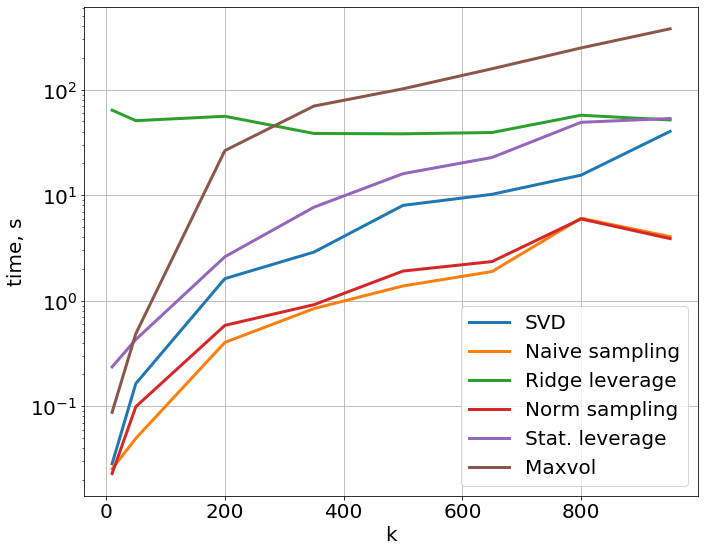

In [3]:
plt.figure(figsize=(11, 9))
fontsize = 20
plt.plot(k_values, svd_times, label='SVD', linewidth=3)
plt.plot(k_values, naive_times, label='Naive sampling', linewidth=3)
plt.plot(k_values, ridge_times, label='Ridge leverage', linewidth=3)
plt.plot(k_values, norm_times, label='Norm sampling', linewidth=3)
plt.plot(k_values, statist_times, label='Stat. leverage', linewidth=3)
plt.plot(k_values, maxvol_times, label='Maxvol', linewidth=3)
plt.legend(fontsize=fontsize)
plt.xticks(fontsize=fontsize)
plt.xlabel('k', fontsize=fontsize)
plt.ylabel('time, s', fontsize=fontsize)
plt.yticks(fontsize=fontsize)
plt.yscale('log')
plt.grid()
plt.show()